<a href="https://colab.research.google.com/github/ao7553/ML-side-hustle/blob/main/pug_bread_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pug vs Bread Image Classifier**

Transfer learning of the VGG-16 convolutional neural network model to classify images of pugs or bread, which often get confused.

<img src="https://drive.google.com/uc?export=view&id=1kBapbUA1oKfmISYU78wFtxL9LA9MgEDx" alt="PugBread" width="450" height="450"/>

### **Step 1: Load necessary libraries**

In [11]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

### **Step 2: Load and preprocess images**

There are three classes of images (pug, bread, neither) separated into three folders (train, valid, test). The dataloader expects the folder structure to be of the form:
`~/train/pug/`, `~/train/bread/`, `~/train/neither/`, and similarly for the validation and test sets.

Data augmentation is used to enhance the training set, leading to a more robust, final trained model. The `neither` folders contain a random selection of images so that the model can classify images without pugs or bread in them.

*Note: The `pug` image dataset was downloaded from https://images.cv/dataset/pug-image-classification-dataset. The `bread` image dataset was downloaded from https://images.cv/dataset/bread-image-classification-dataset. The `neither` image dataset was formed from images contained in the Tiny ImageNet dataset.*

In [12]:
# Define transforms for training, validation, and test sets
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.RandomHorizontalFlip(), # Data augmentation
        transforms.RandomRotation(degrees=25), # Data augmentation
        transforms.ColorJitter(), # Data augmentation
        transforms.CenterCrop(size=224),  # ImageNet standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(size=224),  # ImageNet standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.CenterCrop(size=224),  # ImageNet standards
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Set the data directory
data_dir = '/content/drive/MyDrive/images'

# Load the data
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'valid', 'test']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32, shuffle=True, num_workers=4)
               for x in ['train', 'valid', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'valid', 'test']}
class_names = image_datasets['train'].classes

# Print some statistics
print(f"Classes: {class_names}")
print(f"Number of training images: {dataset_sizes['train']}")
print(f"Number of validation images: {dataset_sizes['valid']}")
print(f"Number of test images: {dataset_sizes['test']}")


Classes: ['bread', 'neither', 'pug']
Number of training images: 3926
Number of validation images: 888
Number of test images: 1638


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Check a batch of the images with class names to ensure that they have loaded correctly.

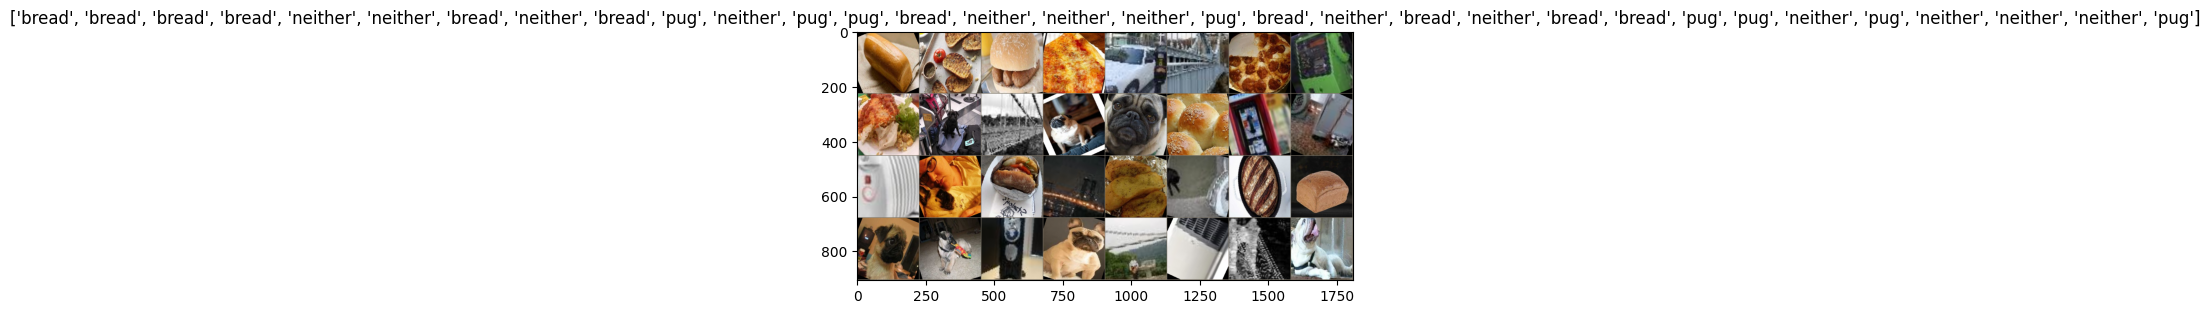

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Function to show an image
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # Pause so plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

# Display the grid of images
imshow(out, title=[class_names[x] for x in classes])

### **Step 3: Load the VGG-16 model**

The VGG-16 model is a 16-layer convolutional neural network. Full details can be found in Simonyan and Zisserman "Very Deep Convolutional Networks for Large-Scale Image Recognition" (2015), https://doi.org/10.48550/arXiv.1409.1556.

In [14]:
# Load the pre-trained VGG-16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze the parameters
for param in vgg16.parameters():
    param.requires_grad = False

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### **Step 4: Define custom classifier**

Before introducing our trainable, custom classifier layer, let's verify the size of the tensor before it enters our classifier. The value will be assigned for input to our custom classifier.

In [15]:
# Verify the size of the tensor before the classifier
# Requires a forward pass up to the classifier
def get_classifier_input_size(model):
    model.eval()
    with torch.no_grad():
        sample_input = torch.zeros(1, 3, 224, 224)  # Batch size 1, 3 colour channels, 224x224 image
        features = model.features(sample_input)
        features = features.view(features.size(0), -1)  # Flatten the tensor
        return features.size(1)

input_size = get_classifier_input_size(vgg16)
print("Input size to the classifier:", input_size)  # Should print 512 * 7 * 7 = 25088

Input size to the classifier: 25088


Now introduce our classifier and the layers that will be trained.

In [16]:
# Define a new classifier using the dynamically determined input size
vgg16.classifier = nn.Sequential(
    nn.Linear(input_size, 256),  # First fully connected layer
    nn.ReLU(),                    # Activation function
    nn.Dropout(p=0.5),            # Dropout for regularization
    nn.Linear(256, 256),        # Second fully connected layer
    nn.ReLU(),                    # Activation function
    nn.Dropout(p=0.5),            # Dropout for regularization
    nn.Linear(256, 3)            # Output layer (3 classes: pugs, bread, neither)
)

# Move the model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
vgg16 = vgg16.to(device)

### **Step 5: Train the model**

Training of the VGG-16 model using the AdamW optimizer and cross entropy loss measure as the loss function. The training process uses gradient accumulation to reduce the computational burden. The gradients in backpropagation will be stored over several batches (in this case 4) before updating the parameters of the model.

*Note: Increase the number of epochs if you have the computational resources (although you get correct classification with only 2 epochs of training).*

In [17]:
# Initialize lists to store metrics
train_losses = []
train_accuracies = []
valid_losses = []
valid_accuracies = []

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(vgg16.classifier.parameters(), lr=0.001, weight_decay=0.01)

# Training the model
num_epochs = 2
accumulation_steps = 4  # Accumulate gradients over 4 batches

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'valid']:
        if phase == 'train':
            vgg16.train()  # Set model to training mode
        else:
            vgg16.eval()   # Set model to evaluation mode

        running_loss = 0.0
        running_corrects = 0

        # Initialize accumulated gradients
        optimizer.zero_grad()

        for batch_idx, (inputs, labels) in enumerate(dataloaders[phase]):
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            with torch.set_grad_enabled(phase == 'train'):
                outputs = vgg16(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # Backward pass (calculate gradients)
                if phase == 'train':
                    loss.backward()

                    # Accumulate gradients for `accumulation_steps` batches
                    if (batch_idx + 1) % accumulation_steps == 0:
                        optimizer.step()  # Update weights
                        optimizer.zero_grad()  # Clear gradients

            # Accumulate loss and correct predictions
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        # If there are remaining accumulated gradients, update weights
        if phase == 'train' and (batch_idx + 1) % accumulation_steps != 0:
            optimizer.step()
            optimizer.zero_grad()
        # Calculate epoch statistics
        epoch_loss = running_loss / len(dataloaders[phase].dataset)
        epoch_acc = running_corrects / len(dataloaders[phase].dataset)

        # Print epoch results
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Convert epoch_loss and epoch_acc to Python floats if they are on GPU
        if isinstance(epoch_loss, torch.Tensor):
            epoch_loss = epoch_loss.item()
        if isinstance(epoch_acc, torch.Tensor):
            epoch_acc = epoch_acc.item()

        # Store metrics for plotting
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accuracies.append(epoch_acc)
        else:
            valid_losses.append(epoch_loss)
            valid_accuracies.append(epoch_acc)

    print()

print('Training complete')


Epoch 1/2
----------
train Loss: 0.1726 Acc: 0.9269
valid Loss: 0.0223 Acc: 0.9955

Epoch 2/2
----------
train Loss: 0.0225 Acc: 0.9939
valid Loss: 0.0060 Acc: 0.9966

Training complete


Plot the training and validation loss and accuracy curves.

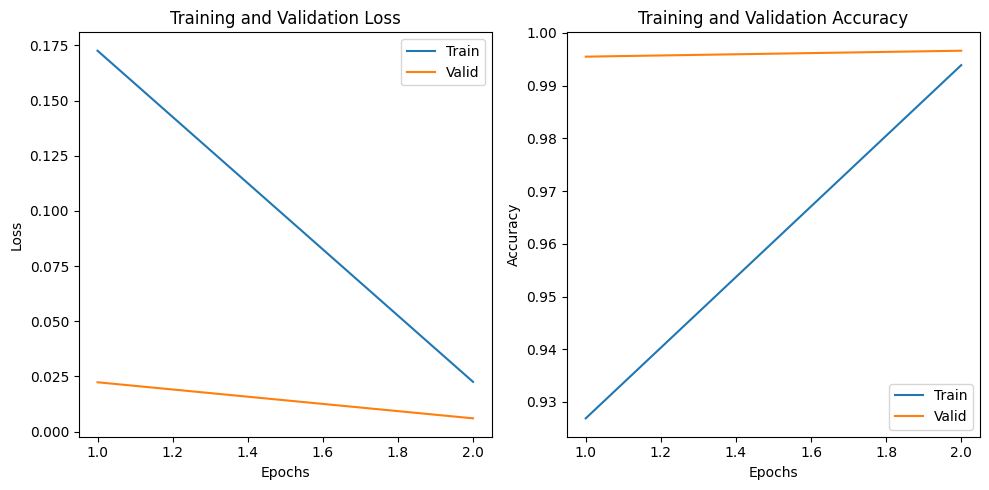

In [18]:
# Plotting the training and validation curves
plt.figure(figsize=(10, 5))

# Plotting the loss curves
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train')
plt.plot(range(1, num_epochs + 1), valid_losses, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Plotting the accuracy curves
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train')
plt.plot(range(1, num_epochs + 1), valid_accuracies, label='Valid')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### **Step 6: Evaluate the model**

Now let's evaluate the trained model on the test set.

In [24]:
# Set the model to evaluate
vgg16.eval()

# Initialize metrics
test_running_loss = 0.0
test_running_corrects = 0

# Iterate over the test data
for inputs, labels in dataloaders['test']:
    inputs = inputs.to(device)
    labels = labels.to(device)

    # Forward pass
    with torch.no_grad():  # Disable gradient calculation for evaluation
        outputs = vgg16(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

    # Accumulate loss and correct predictions
    test_running_loss += loss.item() * inputs.size(0)
    test_running_corrects += torch.sum(preds == labels.data)

# Calculate final loss and accuracy
test_loss = test_running_loss / len(dataloaders['test'].dataset)
test_acc = test_running_corrects / len(dataloaders['test'].dataset)
num_images = len(dataloaders['test'].dataset)

print(f'Test Loss: {test_loss:.4f}, Acc: {test_acc:.4f}, No of images: {num_images}')


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Test Loss: 0.0915, Acc: 0.9835, No of images: 1638


### **Step 7: Test the model on your own images**

Finally, we can use the model on our own images, just add the file path to them.

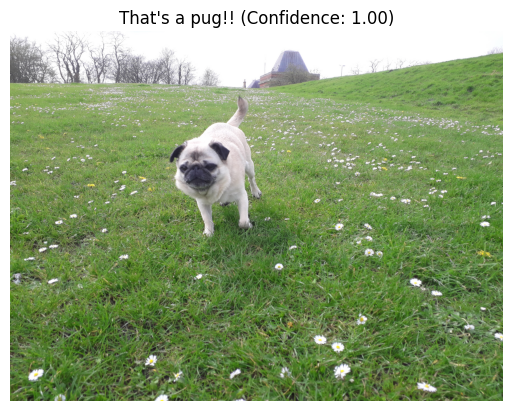

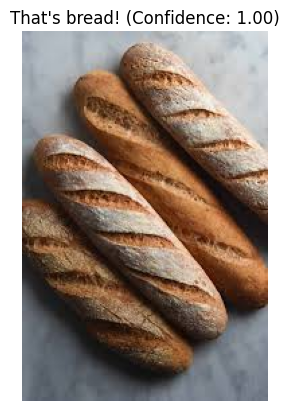

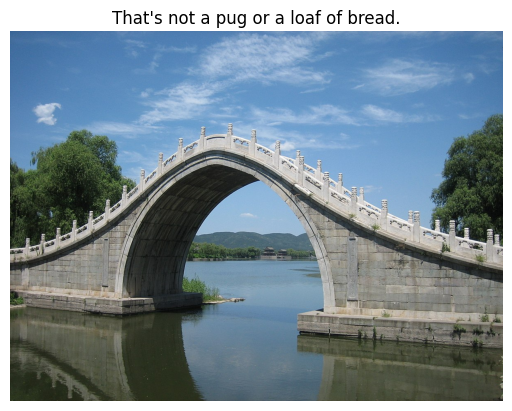

In [25]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Class names
class_names = ['bread','neither', 'pug']

# Confidence threshold of 90% for classification
thresh = 0.9

def classify_image(image_path, threshold=0.6):
    # Load the image
    image = Image.open(image_path).convert('RGB')

    # Apply transformations
    image_tensor = transform(image)

    # Add batch dimension
    image_tensor = image_tensor.unsqueeze(0).to(device)

    # Set the model to evaluation mode
    vgg16.eval()

    # Make predictions
    with torch.no_grad():
        outputs = vgg16(image_tensor)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        max_prob, preds = torch.max(probabilities, 1)

    # Get the predicted class
    predicted_class = preds.item()
    max_prob = max_prob.item()

    # Output the result based on the predicted class
    if predicted_class == 0 and max_prob >= thresh:
        result_text = f"That's bread! (Confidence: {max_prob:.2f})"
    elif predicted_class == 1 and max_prob >= thresh:
        result_text = f"That's not a pug or a loaf of bread. (Confidence: {max_prob:.2f})"
    elif predicted_class == 2 and max_prob >= thresh:
        result_text = f"That's a pug!! (Confidence: {max_prob:.2f})"
    else:
        result_text = "That's not a pug or a loaf of bread."

    # Display the image
    plt.imshow(image)
    plt.title(result_text)
    plt.axis('off')  # Hide axis
    plt.show()

# Test 1: Lola
image_path = '/content/drive/MyDrive/images_pug_bread_test/lola.jpg'
classify_image(image_path)

# Test 2: Bread
image_path = '/content/drive/MyDrive/images_pug_bread_test/bread.jpeg'
classify_image(image_path)

# Test 3: Bridge
image_path = '/content/drive/MyDrive/images_pug_bread_test/bridge.jpeg'
classify_image(image_path)